<a href="https://colab.research.google.com/github/dominicbiela/cnn/blob/main/basic_ccn_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks with Tensorflow in Python (365 Data Science)

## Import Libraries

In [ ]:
!pip install -q tensorflow-datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
tf.__version__

'2.17.0'

### Load MNIST dataset

In [ ]:
# Hyperparameters
BUFFER_SIZE = 70_000
# Bigger batch size speeds up the training process, whilst lower batch size gives better test accuracy
# Best to set the batch size as a power of 2 (2,4,16,32,64,128,256)
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [ ]:
mnist_data, mnist_info = tfds.load('mnist', with_info=True, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
mnist_train, mnist_test = mnist_data['train'], mnist_data['test']

In [ ]:
mnist_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Preprocessing Data

### Scale image

In [ ]:
# TFDS provide images of type tf.uint8, while the model expects tf.float32. Therefore, you need to normalize images
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.

  return image, label

In [ ]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [ ]:
test_data

<_MapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Cache the data for faster processing / cache it before shuffling for a better performance
train_and_validation_data = train_and_validation_data.cache()
test_data = test_data.cache()

### Split training dataset

In [ ]:
# Allow 10% of training data to become validation data
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [ ]:
# mnist_info contains the number of samples
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

### Shuffling the training data

In [ ]:
# Shuffle
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [ ]:
# Skips n number of data p/oints
train_data = train_and_validation_data.skip(num_validation_samples)

# Takes the first n number of data points
validation_data = train_and_validation_data.take(num_validation_samples)

In [ ]:
# Batch the data by the hyperparameter previously set
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples).prefetch(tf.data.AUTOTUNE)

## Create Model

In [ ]:
# Create eachlayer of the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=50, kernel_size=5, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary(line_length = 75)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                │ (None, 24, 24, 50)      │        1,300 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)   │ (None, 12, 12, 50)      │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)              │ (None, 10, 10, 50)      │       22,550 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_1 (MaxPooling2D) │ (None, 5, 5, 50)        │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten (Flatten)              │ (None, 1250)            │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense (Dense)                  │ (None, 10)              │       12,510 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 36,360 (142.03 KB)

 Trainable params: 36,360 (142.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [ ]:
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Stops the training process when validation loss starts to increase for 2 subsequent epics
# More hyperparameters
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True
)

In [ ]:
model.fit(
    train_data,
    epochs = NUM_EPOCHS,
    callbacks = [early_stopping],
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
422/422 - 75s - 178ms/step - accuracy: 0.9258 - loss: 0.2645 - val_accuracy: 0.9772 - val_loss: 0.0717
Epoch 2/20
422/422 - 68s - 162ms/step - accuracy: 0.9784 - loss: 0.0693 - val_accuracy: 0.9857 - val_loss: 0.0524
Epoch 3/20
422/422 - 81s - 193ms/step - accuracy: 0.9846 - loss: 0.0511 - val_accuracy: 0.9862 - val_loss: 0.0445
Epoch 4/20
422/422 - 59s - 140ms/step - accuracy: 0.9874 - loss: 0.0418 - val_accuracy: 0.9895 - val_loss: 0.0352
Epoch 5/20
422/422 - 63s - 148ms/step - accuracy: 0.9891 - loss: 0.0355 - val_accuracy: 0.9913 - val_loss: 0.0324
Epoch 6/20
422/422 - 79s - 188ms/step - accuracy: 0.9903 - loss: 0.0296 - val_accuracy: 0.9962 - val_loss: 0.0176
Epoch 7/20
422/422 - 59s - 141ms/step - accuracy: 0.9919 - loss: 0.0261 - val_accuracy: 0.9933 - val_loss: 0.0209
Epoch 8/20
422/422 - 82s - 195ms/step - accuracy: 0.9927 - loss: 0.0233 - val_accuracy: 0.9955 - val_loss: 0.0168
Epoch 9/20
422/422 - 82s - 194ms/step - accuracy: 0.9940 - loss: 0.0196 - val_accuracy: 

## Testing the model

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9914 - loss: 0.0378


In [ ]:
# Print the results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0378. Test accuracy: 99.14%


## Plotting images and the results

In [ ]:
# Split the data into 2 arrays
for images, labels in test_data.take(1):
  test_images, test_labels = images.numpy(), labels.numpy()

# Reshape images to 28x28 form, suitable for matplotlib (28x28x1)
images_plot = np.reshape(test_images, (10000,28,28))

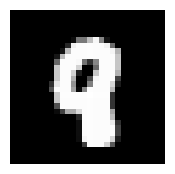

Label: 8


In [ ]:
# Image to be displayed and tested
i = 589

# Plot image
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap='gray', aspect='auto')
plt.show()

# Print correct label
print('Label: {}'.format(test_labels[i-1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<BarContainer object of 10 artists>

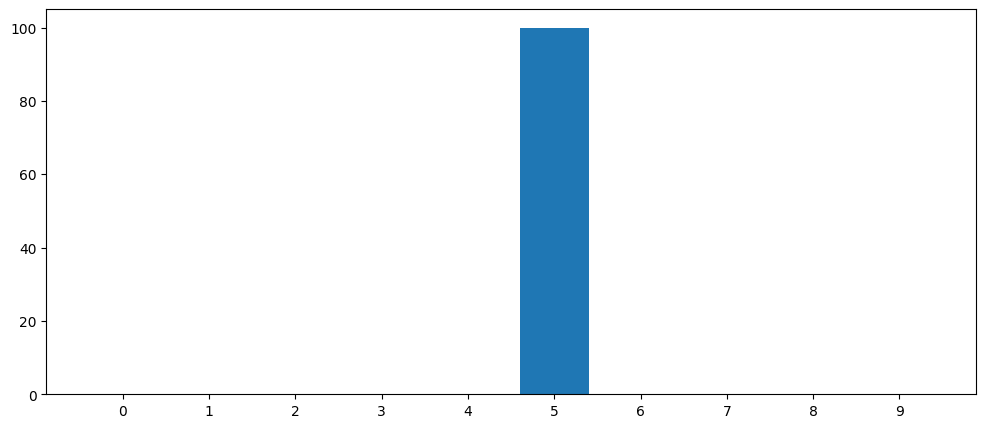

In [ ]:
# Obtain model prediction
predictions = model.predict(test_images[i-1:i])

# Convert predictions into probabilities
probabilities = tf.nn.softmax(predictions).numpy()
# Convert to percentages
probabilities = probabilities * 100

# Create bar chat to plot predictions
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=['0','1','2','3','4','5','6','7','8','9'])